## Import libraries

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import tikzplotlib

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_predict, validation_curve, learning_curve

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from utils.preprocessing import preprocess_duplicated_and_missing, preprocess_duplicated_and_missing_test_set, preprocess_irrelevant_features, one_hot_encode_genres_feature, one_hot_encode_studio_feature, remove_outliers, other_fixes, standardize, standardize2
from utils.feature_extraction import extract_embeddings_features, pca_on_embeddings
from utils.feature_selection import get_mutual_information_matrix, normalize_mutual_information_matrix, select_features_MI_kbest, mrmr, select_features_RFECV
from utils.model_selection import linreg, ModelSelection
from utils.plots import plot_correlation_matrix, plot_mutual_information_matrix, plot_mutual_information_with_target, plot_predictions

from utils.latex import set_size, set_size_square_plot

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [137]:
# declare variables for model selection
N_SPLITS = 5

kf = KFold(n_splits=N_SPLITS)
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [138]:
pd.set_option('display.max_columns', 50)

## Load datasets

In [139]:
def read_datasets():
	X1 = pd.read_csv("datasets/X1.csv", na_values="\\N")
	Y1 = pd.read_csv("datasets/Y1.csv", header=None, names=["revenues"])
	X2 = pd.read_csv("datasets/X2.csv", na_values="\\N")

	X1.drop("Unnamed: 0", axis=1, inplace=True)
	X2.drop("Unnamed: 0", axis=1, inplace=True)
	df = pd.concat([X1, Y1], axis = 1)

	print(f"X1 dataset contains {X1.shape[0]} observations and {X1.shape[1]} features")
	print(f"X2 dataset (for prediction only) contains {X2.shape[0]} observations")

	return df, X2

## Preprocessing

In [140]:
def preprocess(df, train, X2, dataset_name):
	print("-" * 25)
	print(f"PREPROCESSING {dataset_name}...")
	print("-" * 25)
	# remove duplicated observations and preprocessing missing values
	df = preprocess_duplicated_and_missing(df, train)
	# should not remove duplicated and missing values from X2
	# as Y2.csv should contains 1518 predictions
	# impute missing values insted
	X2 = preprocess_duplicated_and_missing_test_set(X2, train)

	# remove (obvious) irrelevant/redundant features
	df = preprocess_irrelevant_features(df)
	X2 = preprocess_irrelevant_features(X2)

	# fix high-cardinality + one-hot-encode studio feature
	df, X2 = one_hot_encode_studio_feature(df, X2)

	# one-hot encode genres feature
	df, X2 = one_hot_encode_genres_feature(df, X2)

	# minor fixes
	df = other_fixes(df)
	X2 = other_fixes(X2)
	return df, X2

## Feature extraction and dimension reduction

In [141]:
def remove_outliers_and_split(X, Y):
	print("-" * 25)
	print("REMOVING OUTLIERS AND TRAIN-TEST SPLIT...")
	print("-" * 25)

	X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 42)

	print(f"training dataset dimension: X_train: {X_train.shape}, y_train: {y_train.shape}")
	print(f"testing dataset dimension: X_test: {X_test.shape}, y_test: {y_test.shape}")

	# remove outliers only on train set
	# as test set should be representative of the reality
	# comment because results not convincing (even a little bit worse most of the time)
	#X_train, y_train = remove_outliers(X_train, y_train, ["runtime", "production_year", "release_year"])

	return X_train, y_train, X_test, y_test

def extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=True):
	print("-" * 25)
	print("FEATURE EXTRACTION...")
	print("-" * 25)

	# extract feature vectors
	X_train_img_embeddings = extract_embeddings_features(X_train["img_embeddings"])
	X_test_img_embeddings = extract_embeddings_features(X_test["img_embeddings"])

	X_train_text_embeddings = extract_embeddings_features(X_train["text_embeddings"])
	X_test_text_embeddings = extract_embeddings_features(X_test["text_embeddings"])

	# should also extract features for X2
	X2_img_embeddings = extract_embeddings_features(X2["img_embeddings"])
	X2_text_embeddings = extract_embeddings_features(X2["text_embeddings"])

	X_train_img_df, X_test_img_df, X2_img_df = pca_on_embeddings(X_train_img_embeddings, X_test_img_embeddings, X2_img_embeddings, X_train.index, X_test.index, X2.index, prefix="img_feature", n_components=5, run_pca=run_pca, non_linear=non_linear)

	X_train_text_df, X_test_text_df, X2_text_df = pca_on_embeddings(X_train_text_embeddings, X_test_text_embeddings, X2_text_embeddings, X_train.index, X_test.index, X2.index, prefix="text_feature", n_components=5, run_pca=run_pca, non_linear=non_linear)

	# drop unnecessary features
	X_train.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X_test.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X2.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)

	# standardize other features
	X_train, X_test, X2 = standardize2(X_train, X_test, X2)

	X_train = pd.concat([X_train, X_train_img_df, X_train_text_df], axis=1)
	X_test = pd.concat([X_test, X_test_img_df, X_test_text_df], axis=1)
	X2 = pd.concat([X2, X2_img_df, X2_text_df], axis=1)


	return X_train, y_train, X_test, y_test, X2

## Model

In [142]:
df, X2 = read_datasets()

train_set = df

# preprocessing 
df, X2 = preprocess(df, train_set, X2, "modeling and prediction datasets")

X1 dataset contains 3540 observations and 13 features
X2 dataset (for prediction only) contains 1518 observations
-------------------------
PREPROCESSING modeling and prediction datasets...
-------------------------
[X] Removing duplicated and missing values
[X] impute missing values (X2 set)
[X] Removing irrelevant features
[X] Removing irrelevant features
[X] One-Hot encoding studio feature
[X] One-Hot encoding genres feature
[X] Minor fixes
[X] Minor fixes


In [143]:
# spliting input and target
X = df.drop("revenues", axis=1)
Y = df["revenues"]

# remove outliers and train-test split
X_train, y_train, X_test, y_test = remove_outliers_and_split(X, Y)

# extract features + standardize (and pca)
X_train, y_train, X_test, y_test, X2 = extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=True)

-------------------------
REMOVING OUTLIERS AND TRAIN-TEST SPLIT...
-------------------------
training dataset dimension: X_train: (2484, 54), y_train: (2484,)
testing dataset dimension: X_test: (621, 54), y_test: (621,)
-------------------------
FEATURE EXTRACTION...
-------------------------


extracting features:   0%|          | 0/2484 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/2484 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1518 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1518 [00:00<?, ?it/s]

5
successfully reduced from 2048 features to 5 features
5
successfully reduced from 768 features to 5 features


In [144]:
def tune_model(model, search_type, k_candidates = [20, 25, 30, 35, 40]):
	features_arr = []
	best_estimators = []
	best_hyperparameters_arr = []
	best_val_scores = []
	best_iter_indexes = []
	best_test_scores = []
	cv_results_arr = []

	for k in k_candidates:
		if k == "all":
			X_train_filtered, X_test_filtered = X_train, X_test
		else:
			X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

		ms = ModelSelection(
			X_train=X_train_filtered,
			y_train=y_train,
			X_test=X_test_filtered,
			y_test=y_test,
			kf=kf,
			scorer=rmse
		)

		searcher = ms.perform_search(
			model=model,
			search_type=search_type
		)

		features = X_train_filtered.columns.tolist()

		# best model among the "n_iter" models tested
		best_estimator = searcher.best_estimator_
		# hyperparameters of the best model
		best_hyperparameters = searcher.best_params_
		# mean rmse score on the validation sets using the best model
		best_val_score = np.round(-searcher.best_score_, 3)
		# index of the arrays (in searcher.cv_results_) which correspond to the best model
		best_iter_index = searcher.best_index_

		# rmse score on the test set using the best model
		best_test_score = np.round(-searcher.score(X_test_filtered, y_test), 3)

		cv_results = searcher.cv_results_

		features_arr.append(features)
		best_estimators.append(best_estimator)
		best_hyperparameters_arr.append(best_hyperparameters)
		best_val_scores.append(best_val_score)
		best_iter_indexes.append(best_iter_index)
		best_test_scores.append(best_test_score)
		cv_results_arr.append(cv_results)

	results = {
		"features_kepts": k_candidates,
		"features": features_arr,
		"best_estimators": best_estimators,
		"hyperparameters": best_hyperparameters_arr,
		"val_scores": best_val_scores,
		"test_scores": best_test_scores,
		"best_iter_indexes": best_iter_indexes,
		"cv_results": cv_results_arr
	}

	return results

In [145]:
def evaluate_model(model, results, filename = ""):
	# get the index of the best model 
	# among the set of best models found through bayesian search
	# for a different number of features
	best_model_idx = np.argmin(results["test_scores"])

	cv_results = results["cv_results"][best_model_idx]
	val_score = results["val_scores"][best_model_idx]
	test_score = results["test_scores"][best_model_idx]
	best_iter_index = results["best_iter_indexes"][best_model_idx]
	best_number_of_features = results["features_kepts"][best_model_idx]

	model_name = model["name"]
	hyperparameters = model["hyperparameters"]
	param_name = model["validation_param"]

	evaluation_plot(cv_results, hyperparameters, val_score, test_score, best_iter_index, param_name, title=f"{model_name} - {best_number_of_features} features", filename=filename)

In [173]:
# evaluate the best model from a bayesian search
def evaluation_plot(cv_results, hyperparameters, val_score, test_score, best_iter_index, param_name, title, filename = ""):
	plt.figure(figsize=(35,15))
	ax = plt.gca()

	if type(cv_results["param_" + param_name].data[0]) == int or type(cv_results["param_" + param_name].data[0]) == float:
		X_axis = np.array(cv_results["param_" + param_name].data, dtype=float)
	# for tuples (like "hidden_layer_sizes")
	else:
		X_axis = np.arange(len(hyperparameters[param_name]))
		x_ticks = np.array(hyperparameters[param_name])
		plt.xticks(ticks=X_axis, labels=x_ticks)
	
	idx_sorted = np.argsort(X_axis)

	score = "rmse"
	color = "k"

	# in my understanding, "test" is the validation set
	for sample, style in (("train", "--"), ("test", "-")):
		sample_score_mean = -cv_results[f"mean_{sample}_score"][idx_sorted]
		sample_score_std = -cv_results[f"std_{sample}_score"][idx_sorted]

		ax.fill_between(
			X_axis[idx_sorted],
			sample_score_mean - sample_score_std,
			sample_score_mean + sample_score_std,
			color = color,
			alpha = 0.1 if sample == "test" else 0
		)

		ax.plot(
			X_axis[idx_sorted],
			sample_score_mean,
			style,
			color = color if sample == "test" else "b",
			alpha = 0.1 if sample == "test" else 0.7,
			label = f"{score} ({'validation' if sample == 'test' else sample})"
		)

	# print([best_score_axis[best_iter_index], ] * 2)

	# # plot an "X" for the best score
	# ax.plot(
	# 	[best_score_axis[best_iter_index], ] * 2,
	# 	[0, val_score],
	# 	linestyle = "-.",
	# 	marker = "x",
	# 	markeredgewidth = 3,
	# 	color = color,
	# 	ms = 8
	# )

	# # Annotate the best score
	# ax.annotate("%0.2f" % val_score, (best_score_axis[best_iter_index], val_score + 0.025))

	ax.plot(
		[X_axis[idx_sorted][0], X_axis[idx_sorted][-1]], 
		[test_score, test_score], 
		linestyle = 'dotted', 
		markeredgewidth = 3, 
		color = 'g', 
		ms=8, 
		label=f"rmse on test set (best model) : {test_score}" 
	)

	plt.xlabel(param_name)
	plt.ylabel("RMSE")
	plt.title(title, fontsize=16)

	plt.legend(loc="best")
	plt.grid(False)

	if filename:
		plt.savefig(f"report/figures/{filename}.pdf", bbox_inches='tight', dpi=300)

	plt.show()
		

In [147]:
def evaluate_model_val_curve(model, results, filename = ""):
	# get the index of the best model 
	# among the set of best models found through bayesian search
	# for a different number of features
	best_model_idx = np.argmin(results["test_scores"])

	n_features = results["features_kepts"][best_model_idx]
	best_estimator = results["best_estimators"][best_model_idx]
	X_train_filtered, _ = select_features_MI_kbest(X_train, y_train, X_test, k=n_features)

	cv_results = results["cv_results"][best_model_idx]
	val_score = results["val_scores"][best_model_idx]
	test_score = results["test_scores"][best_model_idx]
	best_iter_index = results["best_iter_indexes"][best_model_idx]
	best_number_of_features = results["features_kepts"][best_model_idx]

	model_name = model["name"]
	hyperparameters = model["hyperparameters"]
	param_name = model["validation_param"]

	evaluation_plot_val_curve(cv_results, hyperparameters, val_score, test_score, best_iter_index, X_train_filtered, y_train, best_estimator, param_name, title=f"{model_name} - {best_number_of_features} features", filename=filename)

In [172]:
# evaluate the best model from a bayesian search
def evaluation_plot_val_curve(cv_results, hyperparameters, val_score, test_score, best_iter_index, X_train, y_train, best_estimator, param_name, title, filename = ""):
	plt.figure(figsize=(25,15))
	ax = plt.gca()

	if type(cv_results["param_" + param_name].data[0]) == int or type(cv_results["param_" + param_name].data[0]) == float:
		X_axis = np.array(cv_results["param_" + param_name].data, dtype=float)
	# for tuples (like "hidden_layer_sizes")
	else:
		X_axis = np.arange(len(hyperparameters[param_name]))
		x_ticks = np.array(hyperparameters[param_name])
		plt.xticks(ticks=X_axis, labels=x_ticks)
	
	idx_sorted = np.argsort(X_axis)

	train_scores, val_scores = validation_curve(best_estimator, X_train, y_train, param_name=param_name, param_range=np.array(hyperparameters[param_name]), cv=kf, scoring=rmse, error_score=0, n_jobs=-1)

	score = "rmse"
	color = "k"

	# in my understanding, "test" is the validation set
	for sample_type, sample, style in (("train", train_scores, "--"), ("val", val_scores, "-")):
		sample_score_mean = -np.mean(sample, axis=1)
		sample_score_std = -np.std(sample, axis=1)

		ax.fill_between(
			X_axis[idx_sorted],
			sample_score_mean - sample_score_std,
			sample_score_mean + sample_score_std,
			color = color,
			alpha = 0.1 if sample_type == "val" else 0
		)

		ax.plot(
			X_axis[idx_sorted],
			sample_score_mean,
			style,
			color = color if sample_type == "val" else "b",
			alpha = 0.1 if sample_type == "val" else 0.7,
			label = f"{score} ({'validation' if sample_type == 'val' else sample_type})"
		)

	# # plot an "X" for the best score
	# ax.plot(
	# 	[X_axis[best_iter_index], ] * 2,
	# 	[0, val_score],
	# 	linestyle = "-.",
	# 	marker = "x",
	# 	markeredgewidth = 3,
	# 	color = color,
	# 	ms = 8
	# )

	# # Annotate the best score
	# ax.annotate("%0.2f" % val_score, (X_axis[best_iter_index], val_score + 0.025))

	ax.plot(
		[X_axis[idx_sorted][0], X_axis[idx_sorted][-1]], 
		[test_score, test_score], 
		linestyle = 'dotted', 
		markeredgewidth = 3, 
		color = 'g', 
		ms=8, 
		label=f"rmse on test set (best model) : {test_score}" 
	)

	plt.xlabel(param_name)
	plt.ylabel("RMSE")
	plt.title(title, fontsize=16)

	plt.legend(loc="best")
	plt.grid(False)

	if filename:
		plt.savefig(f"report/figures/{filename}.pdf", bbox_inches='tight', dpi=300)

	plt.show()

In [149]:
#MI_matrix = get_mutual_information_matrix(X_train)
#plot_mutual_information_matrix(X_train, MI_matrix)
#plt.savefig("report/figures/mi_matrix.pdf", bbox_inches='tight', dpi=300)

In [150]:
#plot_mutual_information_with_target(X_train, y_train)
#plt.savefig("report/figures/mi_with_target.pdf", bbox_inches='tight', dpi=300)

In [151]:
# drop redundant features: production year and text_feature0
redundant_features = ["production_year", "text_feature0"]

X_train.drop(redundant_features, axis=1, inplace=True)
X_test.drop(redundant_features, axis=1, inplace=True)

In [152]:
#plot_mutual_information_with_target(X_train, y_train)

### Linear Regression

In [153]:
print("+" * 25)
print("Linear Regression")
print("+" * 25)

k_candidates = [5, 10, 15, 20, 25, 30, 35, 40]

val_scores = []
test_scores = []
estimators = []

lr = {
	"name": "Linear Regression"
}

for k in k_candidates:
	X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

	val_score, rmse_score, r2, estimator = linreg(X_train_filtered, y_train, X_test_filtered, y_test, kf, rmse)

	val_scores.append(round(val_score, 3))
	test_scores.append(round(rmse_score, 3))
	estimators.append(estimator)

	print(f"val rmse: {round(val_score, 3)}")
	print(f"test rmse: {round(rmse_score, 3)}")
	print(f"test r2: {round(r2, 3)}")

lr_results = {
	"features_kept": k_candidates,
	"val_score": val_scores,
	"test_score": test_scores,
	"estimator": estimators
}

pd.DataFrame.from_dict(lr_results)

+++++++++++++++++++++++++
Linear Regression
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
val rmse: 162979024.923
test rmse: 115439962.511
test r2: -0.643
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 10 features
val rmse: 97600842.196
test rmse: 102986401.124
test r2: -0.307
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features
val rmse: 81464290.288
test rmse: 96037491.095
test r2: -0.137
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 20 features
val rmse: 68485812.022
test rmse: 87689973.907
test r2: 0.052
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 25 features
val rms

,features_kept,val_score,test_score,estimator
0,5,1.629790e+08,1.154400e+08,TransformedTargetRegressor(func=<ufunc 'log1p'...
1,10,9.760084e+07,1.029864e+08,TransformedTargetRegressor(func=<ufunc 'log1p'...
2,15,8.146429e+07,9.603749e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
3,20,6.848581e+07,8.768997e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
4,25,6.936823e+07,8.719581e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
5,30,6.844734e+07,8.576946e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
6,35,6.869541e+07,8.564467e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...
7,40,7.006344e+07,8.672778e+07,TransformedTargetRegressor(func=<ufunc 'log1p'...


### K-Nearest Neighbors

In [184]:
print("+" * 25)
print("K-Nearest Neighbors")
print("+" * 25)

KNN_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=KNeighborsRegressor(), func=np.log1p, inverse_func=np.expm1))
])

KNN = {
	"name": "K-Nearest Neighbors",
	"instance": KNN_pipe,
	"hyperparameters": {
		"model__regressor__n_neighbors": np.arange(1, 50, 1, dtype=int),
		"model__regressor__p": [1, 2],
		# distance weights make the model overfit a lot
		"model__regressor__weights": ["uniform"]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__n_neighbors"
}

knn_results = tune_model(model=KNN, search_type="gs", k_candidates=[3, 5, 7, 9, 11, 13, 15])

+++++++++++++++++++++++++
K-Nearest Neighbors
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 3 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 7 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 9 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 11 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 13 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 fea

In [185]:
pd.DataFrame.from_dict(knn_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,3,"[n_votes, runtime, release_year]",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 5, 'model__r...",6.580250e+07,8.042506e+07,9,"{'mean_fit_time': [0.0041847705841064455, 0.00..."
1,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 3, 'model__r...",6.318843e+07,8.158935e+07,4,"{'mean_fit_time': [0.003257608413696289, 0.004..."
2,7,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 3, 'model__r...",6.324923e+07,8.037934e+07,4,"{'mean_fit_time': [0.003437519073486328, 0.003..."
3,9,"[n_votes, runtime, release_year, studio_BV, st...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 3, 'model__r...",6.410077e+07,8.093481e+07,4,"{'mean_fit_time': [0.003376197814941406, 0.003..."
4,11,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 4, 'model__r...",6.379245e+07,8.182334e+07,6,"{'mean_fit_time': [0.003571224212646484, 0.003..."
5,13,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 4, 'model__r...",6.412298e+07,8.179303e+07,7,"{'mean_fit_time': [0.003524637222290039, 0.003..."
6,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 3, 'model__r...",6.225926e+07,7.982674e+07,4,"{'mean_fit_time': [0.0037721633911132813, 0.00..."


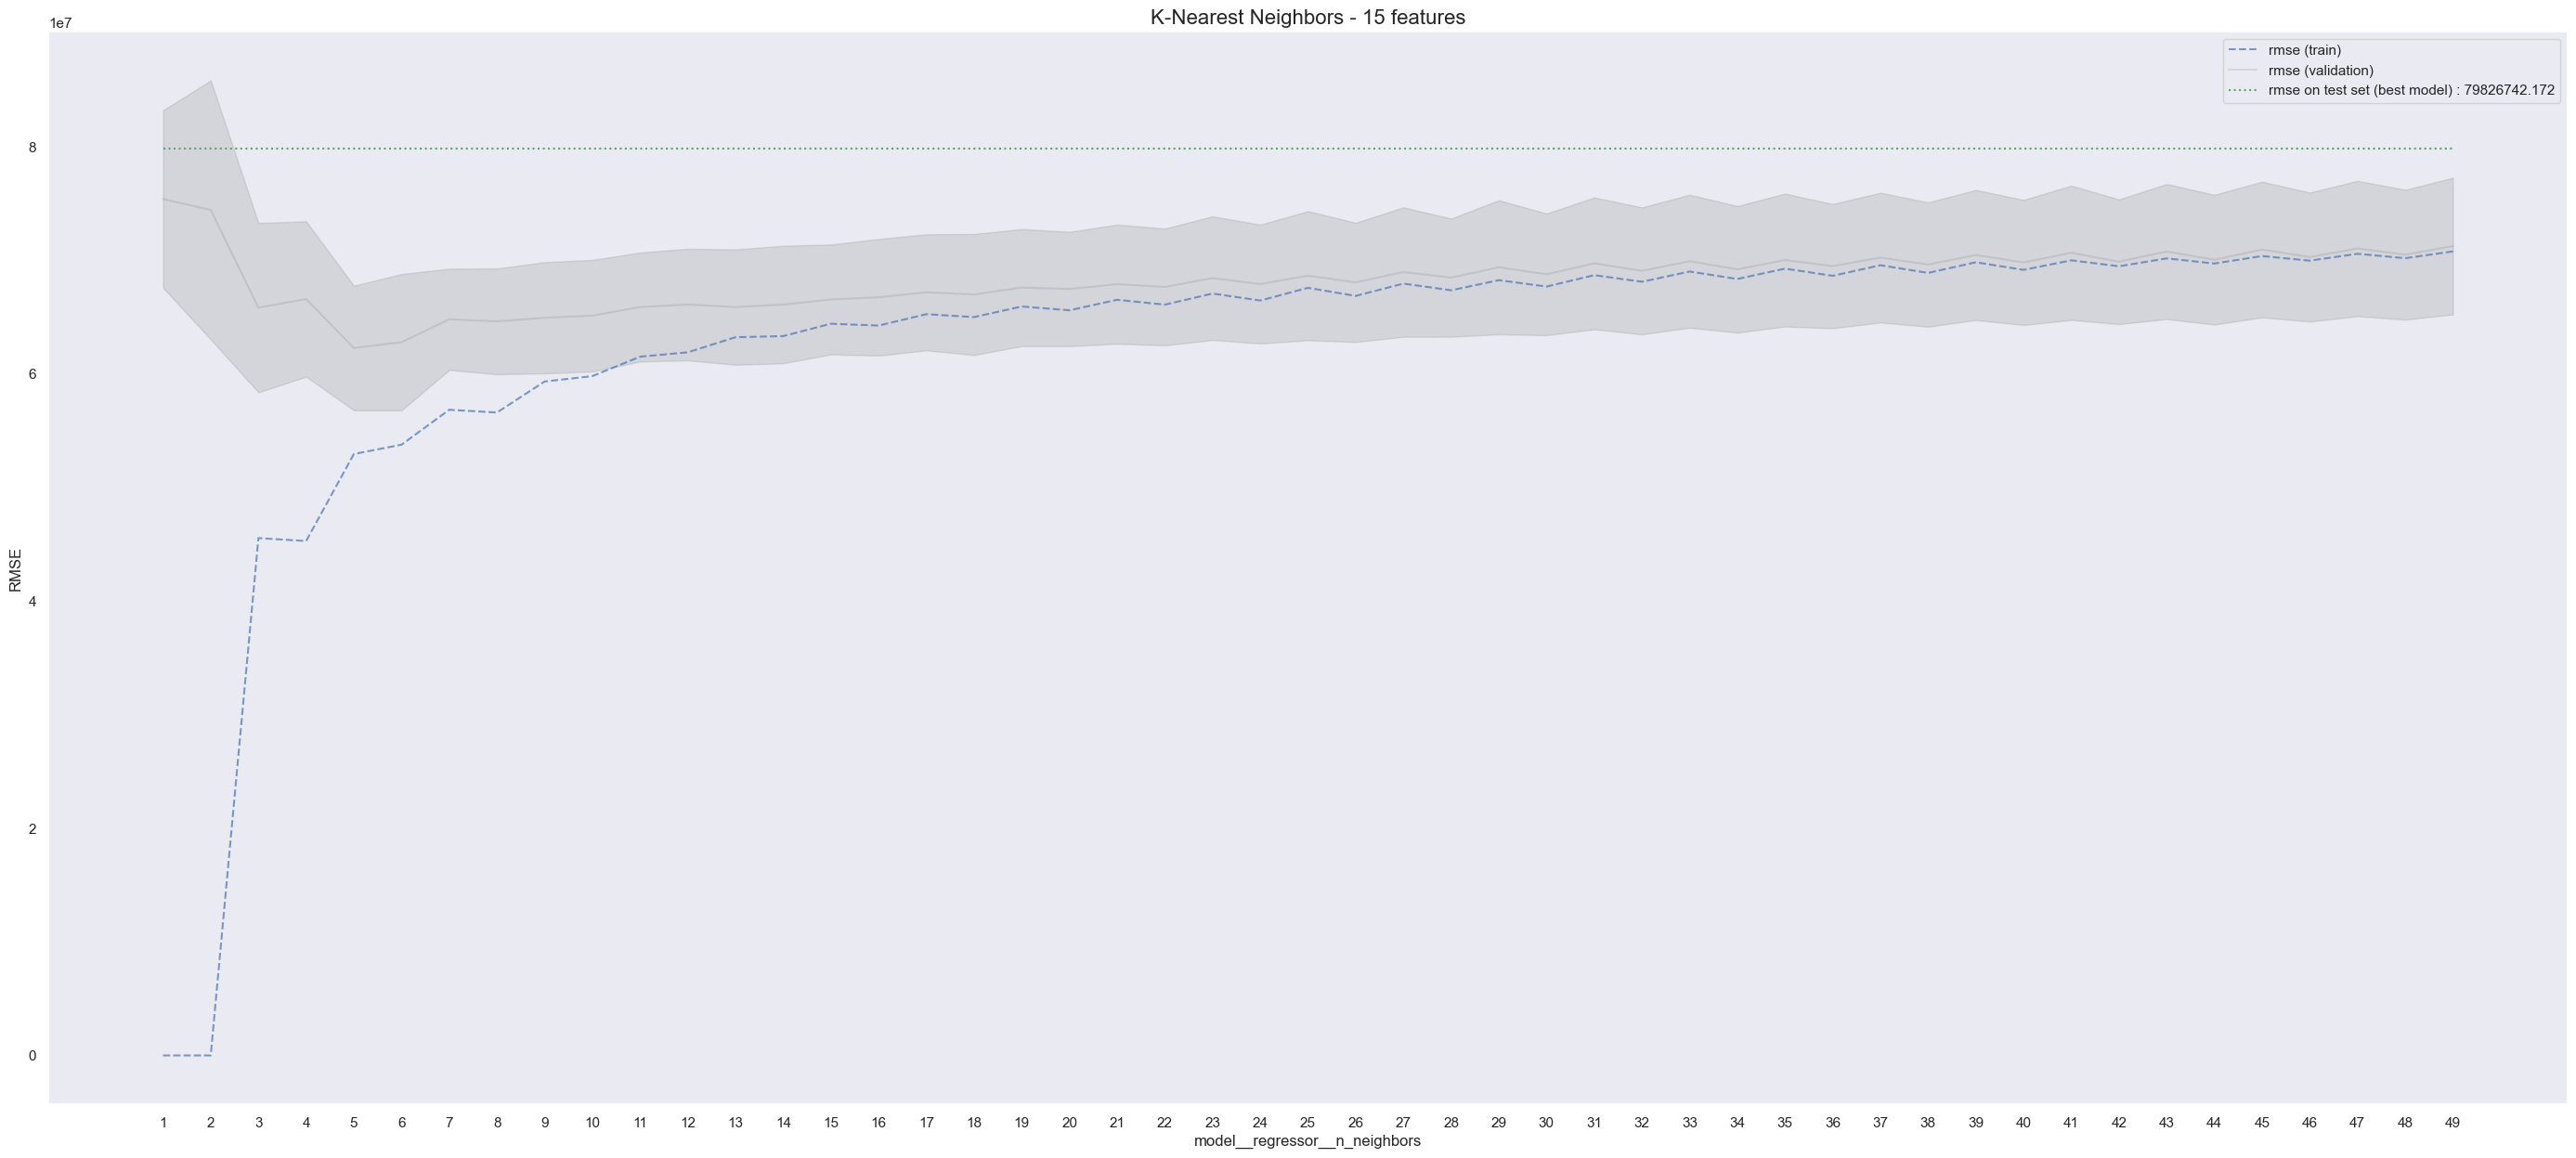

In [186]:
evaluate_model(KNN, knn_results, filename="knn_eval1")

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features


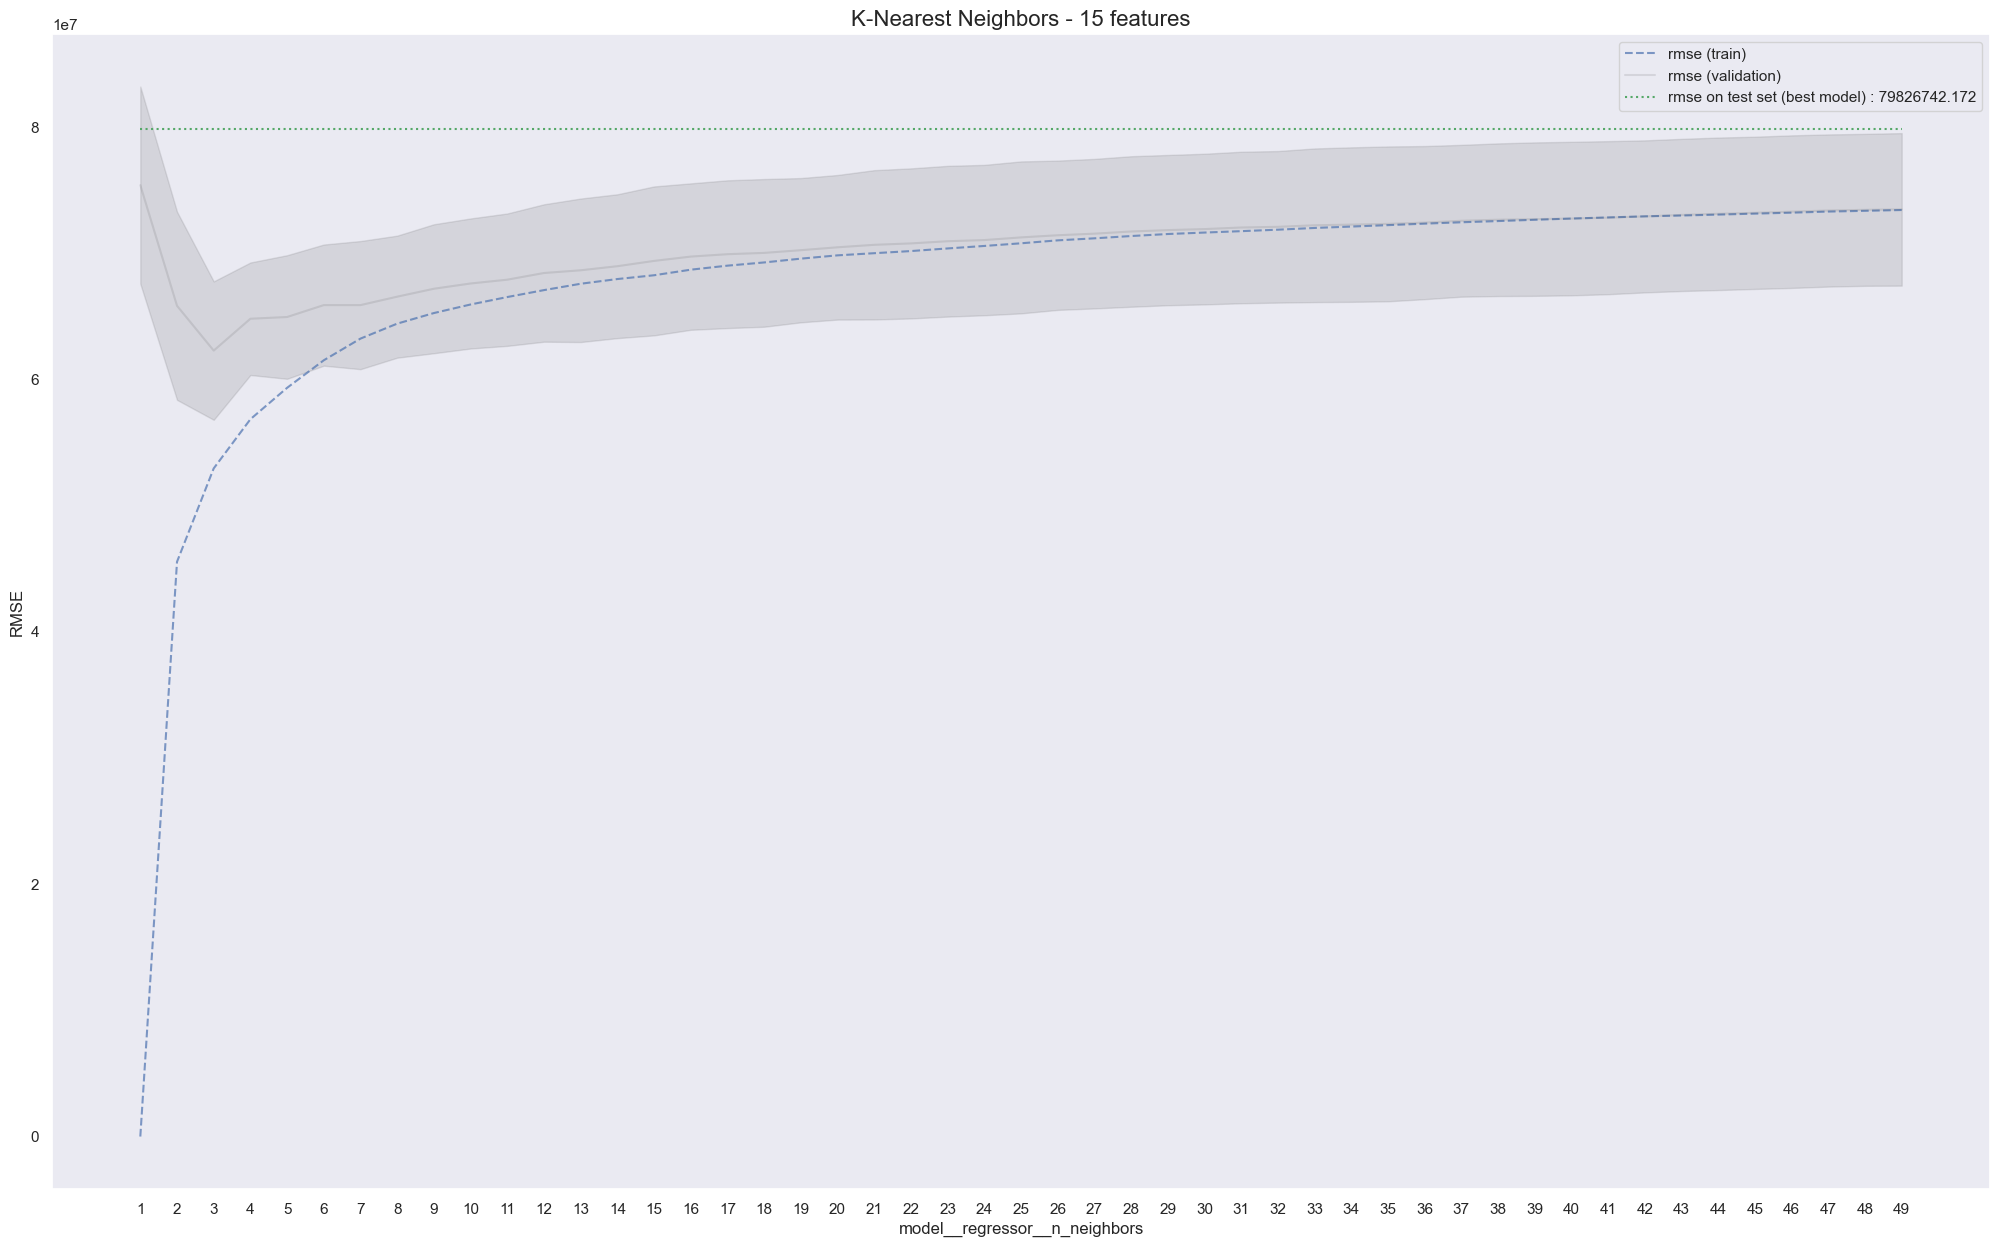

In [187]:
evaluate_model_val_curve(KNN, knn_results, filename="knn_eval1")

In [158]:
knn_results["hyperparameters"][np.argmin(knn_results["test_scores"])]

{'model__regressor__n_neighbors': 3,
 'model__regressor__p': 1,
 'model__regressor__weights': 'uniform'}

In [159]:
print("+" * 25)
print("K-Nearest Neighbors")
print("+" * 25)

KNN_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=KNeighborsRegressor(), func=np.log1p, inverse_func=np.expm1))
])

KNN = {
	"name": "K-Nearest Neighbors",
	"instance": KNN_pipe,
	"hyperparameters": {
		"model__regressor__n_neighbors": np.arange(7, 50, 1, dtype=int),
		"model__regressor__p": [1, 2],
		# distance weights make the model overfit a lot
		"model__regressor__weights": ["uniform"]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__n_neighbors"
}

knn_results2 = tune_model(model=KNN, search_type="gs", k_candidates=[3, 5, 7, 9, 11, 13, 15])

+++++++++++++++++++++++++
K-Nearest Neighbors
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 3 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 7 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 9 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 11 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 13 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 fea

In [160]:
pd.DataFrame.from_dict(knn_results2)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,3,"[n_votes, runtime, release_year]",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 8, 'model__r...",6.614451e+07,8.036358e+07,3,"{'mean_fit_time': [0.0028122901916503907, 0.00..."
1,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.642669e+07,8.166615e+07,1,"{'mean_fit_time': [0.002979564666748047, 0.002..."
2,7,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.556355e+07,8.103123e+07,1,"{'mean_fit_time': [0.003052234649658203, 0.002..."
3,9,"[n_votes, runtime, release_year, studio_BV, st...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.572782e+07,8.176009e+07,0,"{'mean_fit_time': [0.0033449649810791014, 0.00..."
4,11,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.584933e+07,8.292961e+07,0,"{'mean_fit_time': [0.0031647682189941406, 0.00..."
5,13,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.542121e+07,8.271016e+07,0,"{'mean_fit_time': [0.003599071502685547, 0.003..."
6,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__n_neighbors': 7, 'model__r...",6.586219e+07,8.408779e+07,0,"{'mean_fit_time': [0.003784799575805664, 0.004..."


-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 3 features


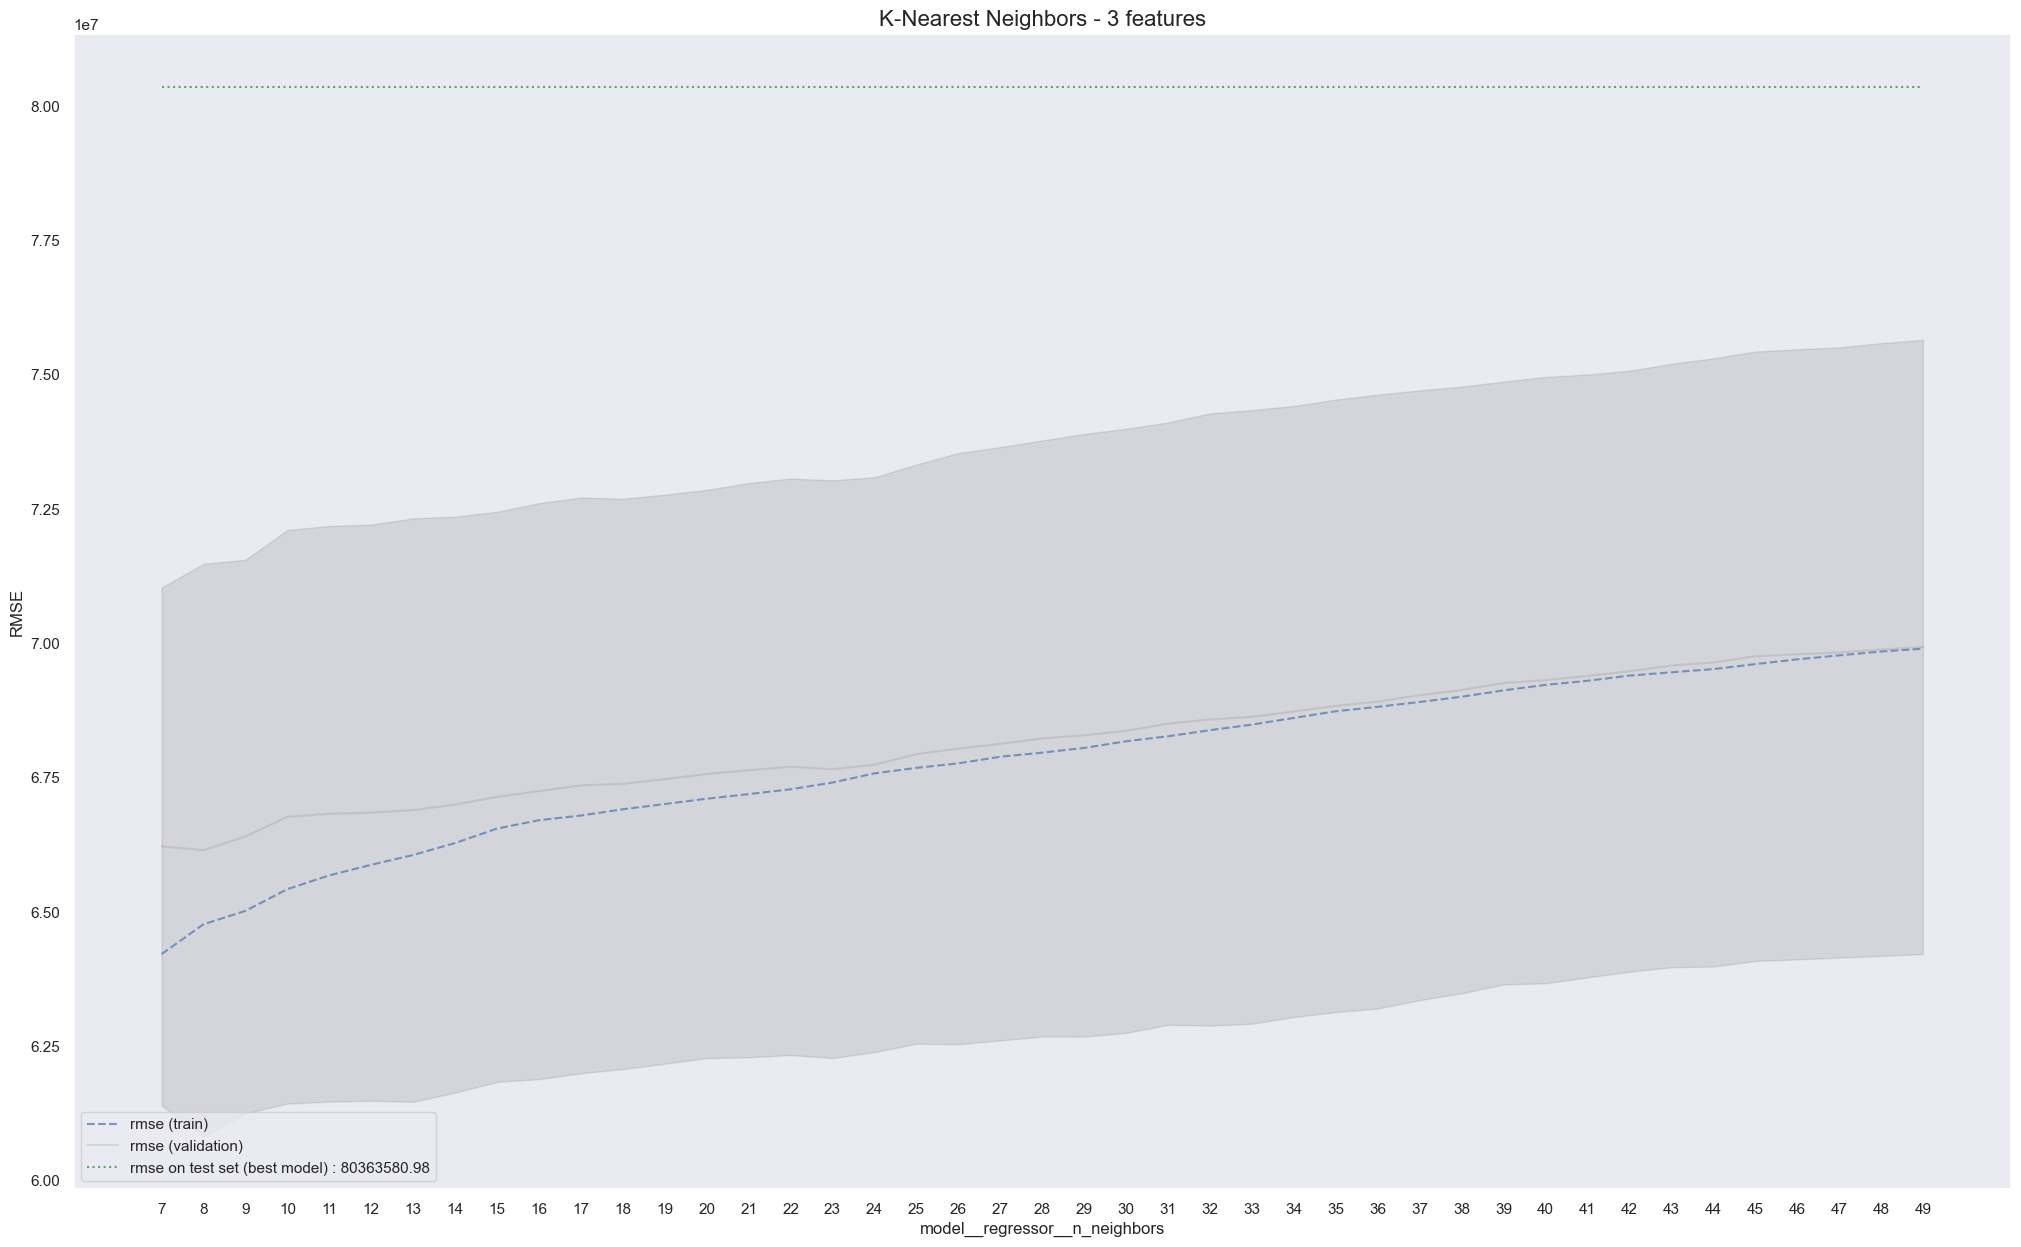

In [176]:
evaluate_model_val_curve(KNN, knn_results2, filename="knn_eval2")

In [162]:
knn_results2["hyperparameters"][np.argmin(knn_results2["test_scores"])]

{'model__regressor__n_neighbors': 8,
 'model__regressor__p': 2,
 'model__regressor__weights': 'uniform'}

### Multi-Layer Perceptron

In [163]:
MLP_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log1p, inverse_func=np.expm1))
])

MLP = {
	"name": "Multi-Layer Perceptron",
	"instance": MLP_pipe,
	"hyperparameters": {
		# doesn't seem to need to go over 3 layers
		"model__regressor__hidden_layer_sizes": [(10,),(25,),(50,),(75,),(100,),(25,25),(50,25),(50,50),(100,50),(100,75),(100,50,25),(50,25,25,10),(100,75,50,25),],
		# thanh seems the best
		"model__regressor__activation": ["tanh"], #["identity", "logistic", "tanh", "relu"],
		# stick to adam solver since sgd gives overflow
		"model__regressor__solver": ["adam"],
		# 1e-01 seems the best
		"model__regressor__alpha": [1e-05], #[1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06], # https://scikit-learn.org/stable/modules/neural_networks_supervised.html
		# adam solver only support constant learning rate
		"model__regressor__learning_rate": ["constant"],
		"model__regressor__learning_rate_init": [0.001], #10.0 ** -np.arange(0, 5),
		"model__regressor__max_iter": [200]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__hidden_layer_sizes"
}

# bayesian search does not support tuple for hyperparameters search
# fallback to grid search
mlp_results = tune_model(model=MLP, search_type="gs", k_candidates=[5, 15, 25, 35, "all"])

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 25 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 35 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

In [164]:
pd.DataFrame.from_dict(mlp_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.649791e+07,8.101430e+07,9,"{'mean_fit_time': [0.5594084739685059, 0.76777..."
1,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.254935e+07,7.469468e+07,9,"{'mean_fit_time': [0.578030776977539, 0.815781..."
2,25,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.124316e+07,7.491785e+07,9,"{'mean_fit_time': [0.6292613506317138, 0.83902..."
3,35,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.147883e+07,7.385074e+07,9,"{'mean_fit_time': [0.6776080131530762, 1.03823..."
4,all,"[ratings, n_votes, runtime, release_year, stud...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'tanh', 'mode...",6.041807e+07,8.124382e+07,9,"{'mean_fit_time': [0.9284840106964112, 1.14645..."


/var/folders/l6/8s1fvb2x2kv47nlbcr_8hsc80000gn/T/ipykernel_8182/2724559367.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_ticks = np.array(hyperparameters[param_name])


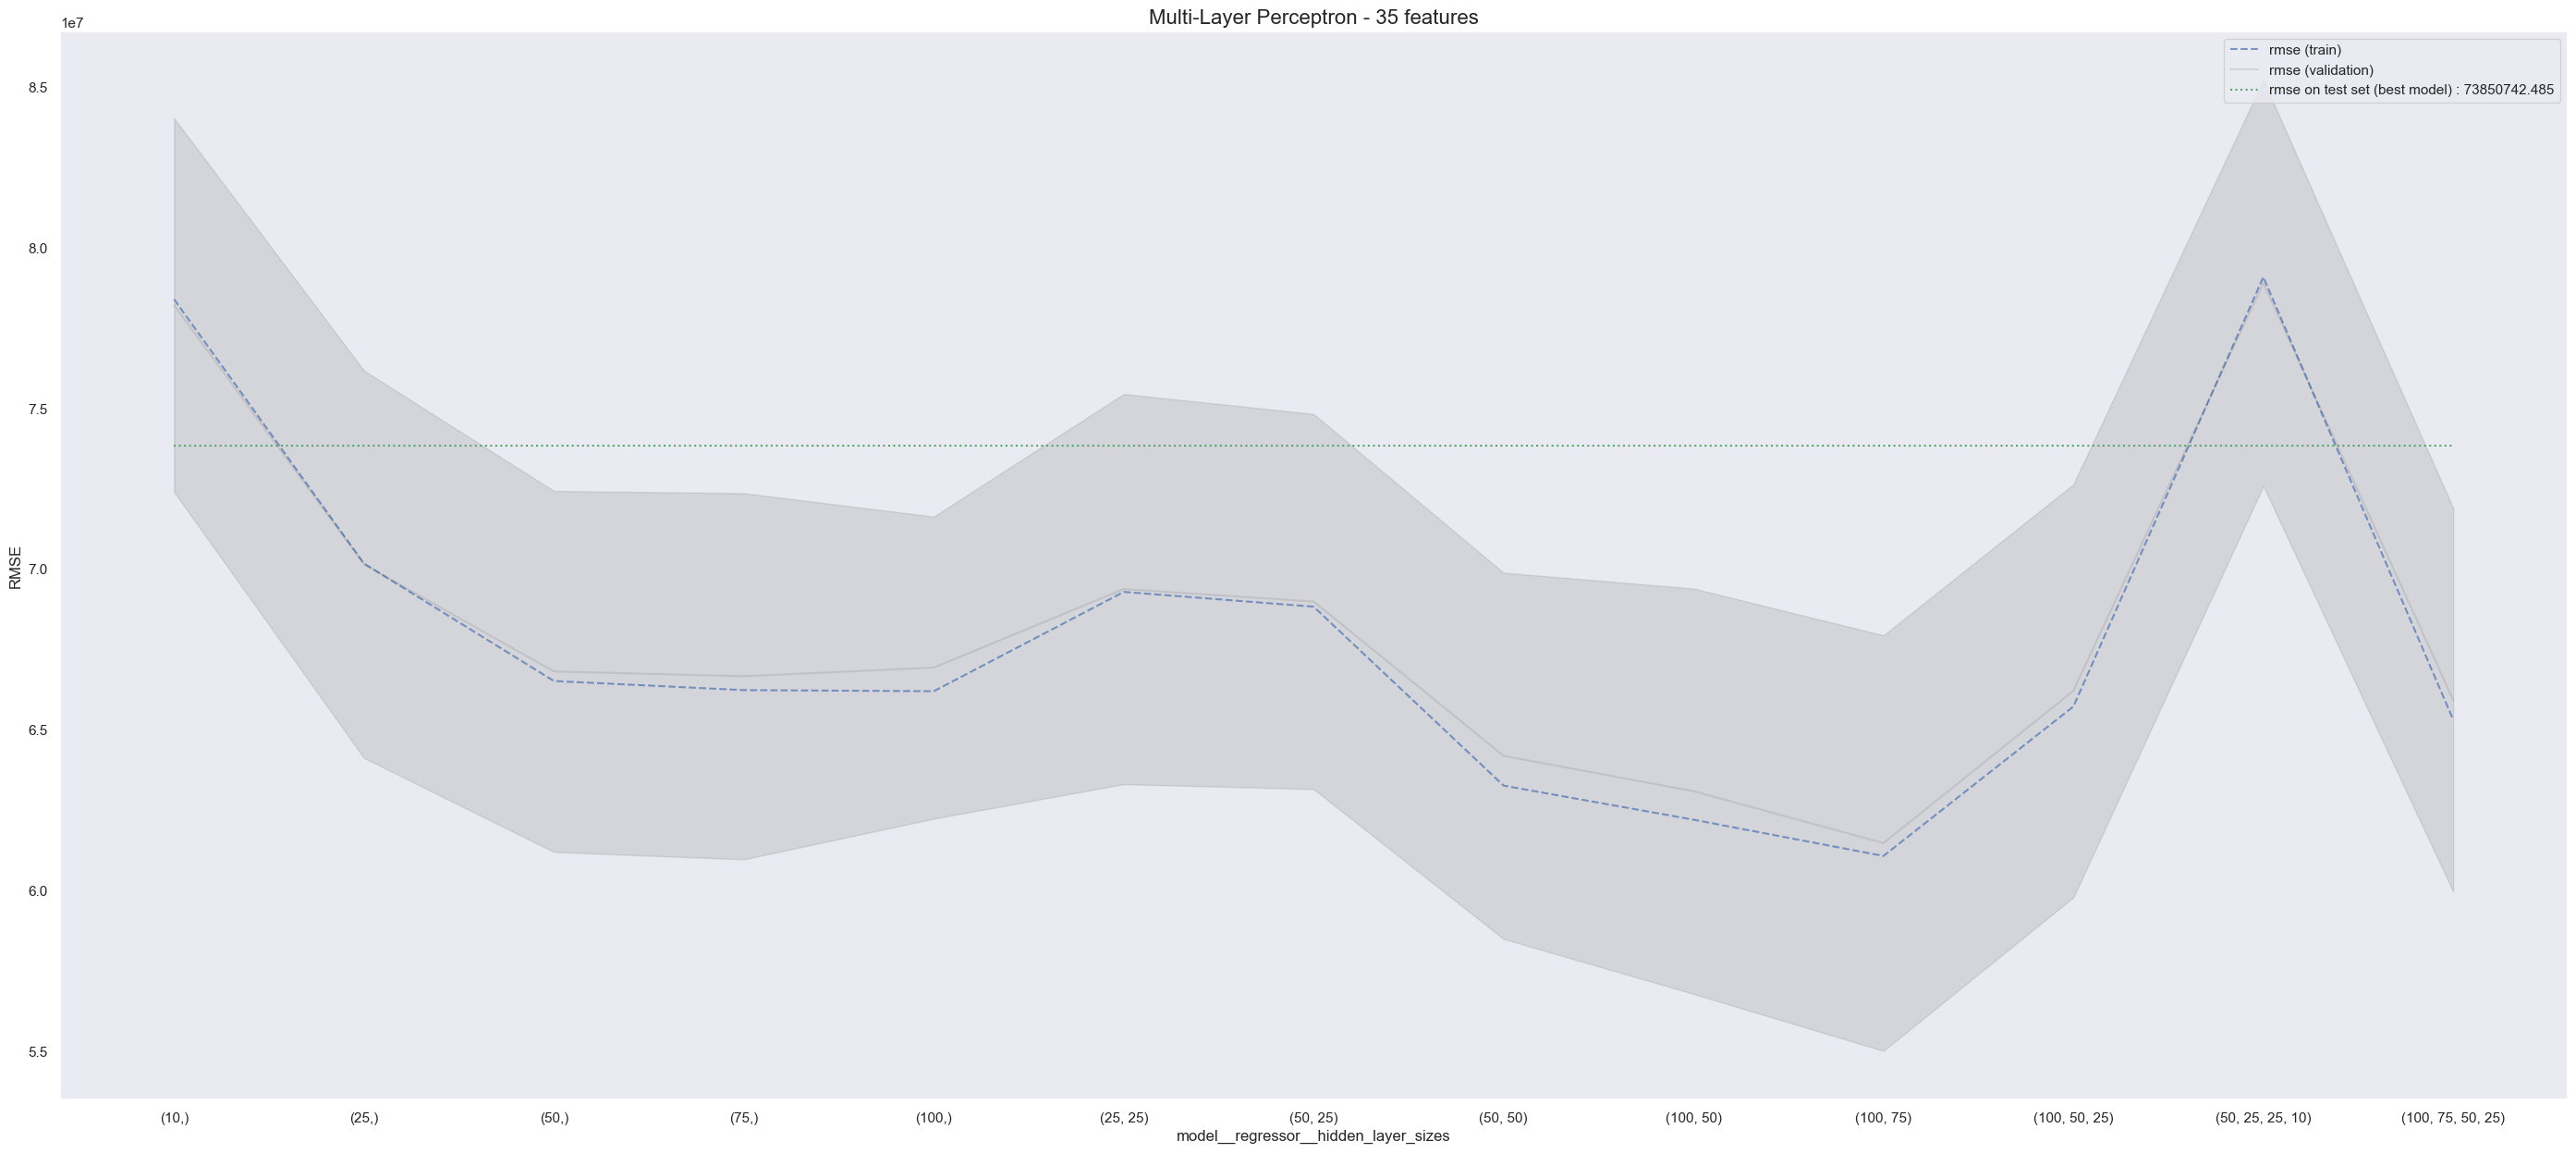

In [177]:
evaluate_model(MLP, mlp_results, filename="mlp_eval")

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 35 features


/var/folders/l6/8s1fvb2x2kv47nlbcr_8hsc80000gn/T/ipykernel_8182/755553203.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_ticks = np.array(hyperparameters[param_name])
/var/folders/l6/8s1fvb2x2kv47nlbcr_8hsc80000gn/T/ipykernel_8182/755553203.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores, val_scores = validation_curve(best_estimator, X_train, y_train, param_name=param_name, param_range=np.array(hyperparameters[param_name]), cv=kf, scoring=rmse, error_score=0, n_jobs=-1)
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/si

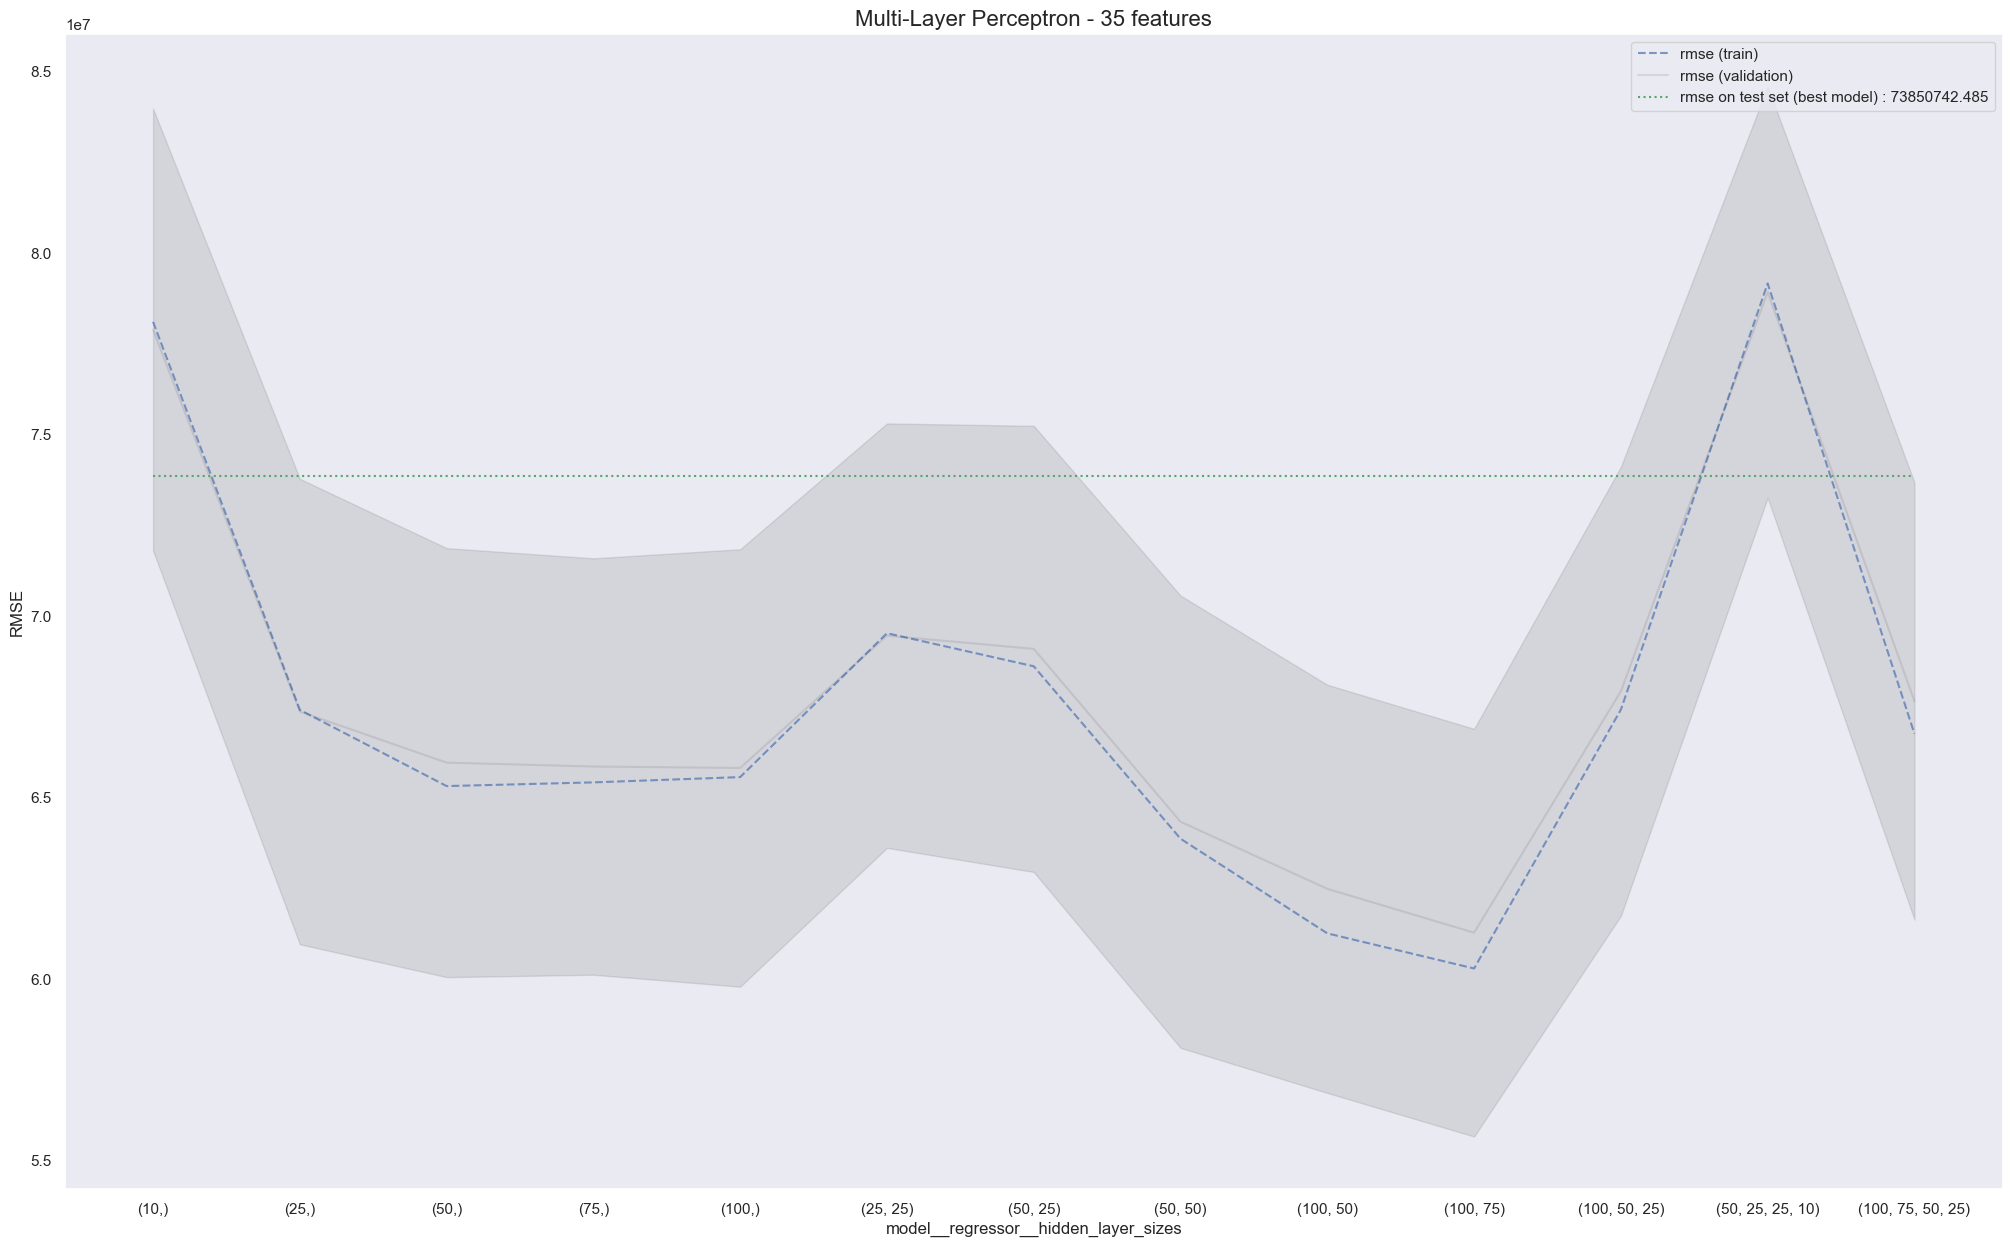

In [178]:
evaluate_model_val_curve(MLP, mlp_results, filename="mlp_eval")

In [167]:
mlp_results["hyperparameters"][np.argmin(mlp_results["test_scores"])]

{'model__regressor__activation': 'tanh',
 'model__regressor__alpha': 1e-05,
 'model__regressor__hidden_layer_sizes': (100, 75),
 'model__regressor__learning_rate': 'constant',
 'model__regressor__learning_rate_init': 0.001,
 'model__regressor__max_iter': 200,
 'model__regressor__solver': 'adam'}

### Random Forest

#### Tuning

In [168]:
random_forest_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42), func=np.log1p, inverse_func=np.expm1))
])

rf = {
	"name": "Random Forest",
	"instance": random_forest_pipe,
	"hyperparameters": {
		"model__regressor__n_estimators": [100, 200, 300, 400, 500],
		#"model__regressor__criterion": ["absolute_error"], #["absolute_error", "squared_error"],
		"model__regressor__max_depth": [80, 90, 100, 110, 120, 130, 140, 150, None], # none means unbounded max depth
		"model__regressor__min_samples_split": [5, 10, 15],
		"model__regressor__min_samples_leaf": [1, 2, 4],
		"model__regressor__bootstrap": [True, False],
		"model__regressor__max_features": ["auto", "log2", "sqrt"]
	},
	"n_iter": 30,
	"validation_param": "model__regressor__n_estimators"
}

rf_results = tune_model(model=rf, search_type="bs", k_candidates=[5, 10, 15, 20, 25])

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 10 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 20 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 25 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

In [169]:
pd.DataFrame.from_dict(rf_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.465968e+07,7.943951e+07,13,"{'mean_fit_time': [1.0890264511108398, 0.25751..."
1,10,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.342462e+07,7.813757e+07,29,"{'mean_fit_time': [0.9847787380218506, 0.23359..."
2,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.316133e+07,7.743044e+07,10,"{'mean_fit_time': [1.0642988681793213, 0.24252..."
3,20,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.254910e+07,7.711319e+07,18,"{'mean_fit_time': [1.1644136905670166, 0.25702..."
4,25,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__bootstrap': True, 'model__...",6.283723e+07,7.706336e+07,14,"{'mean_fit_time': [1.313012456893921, 0.232667..."


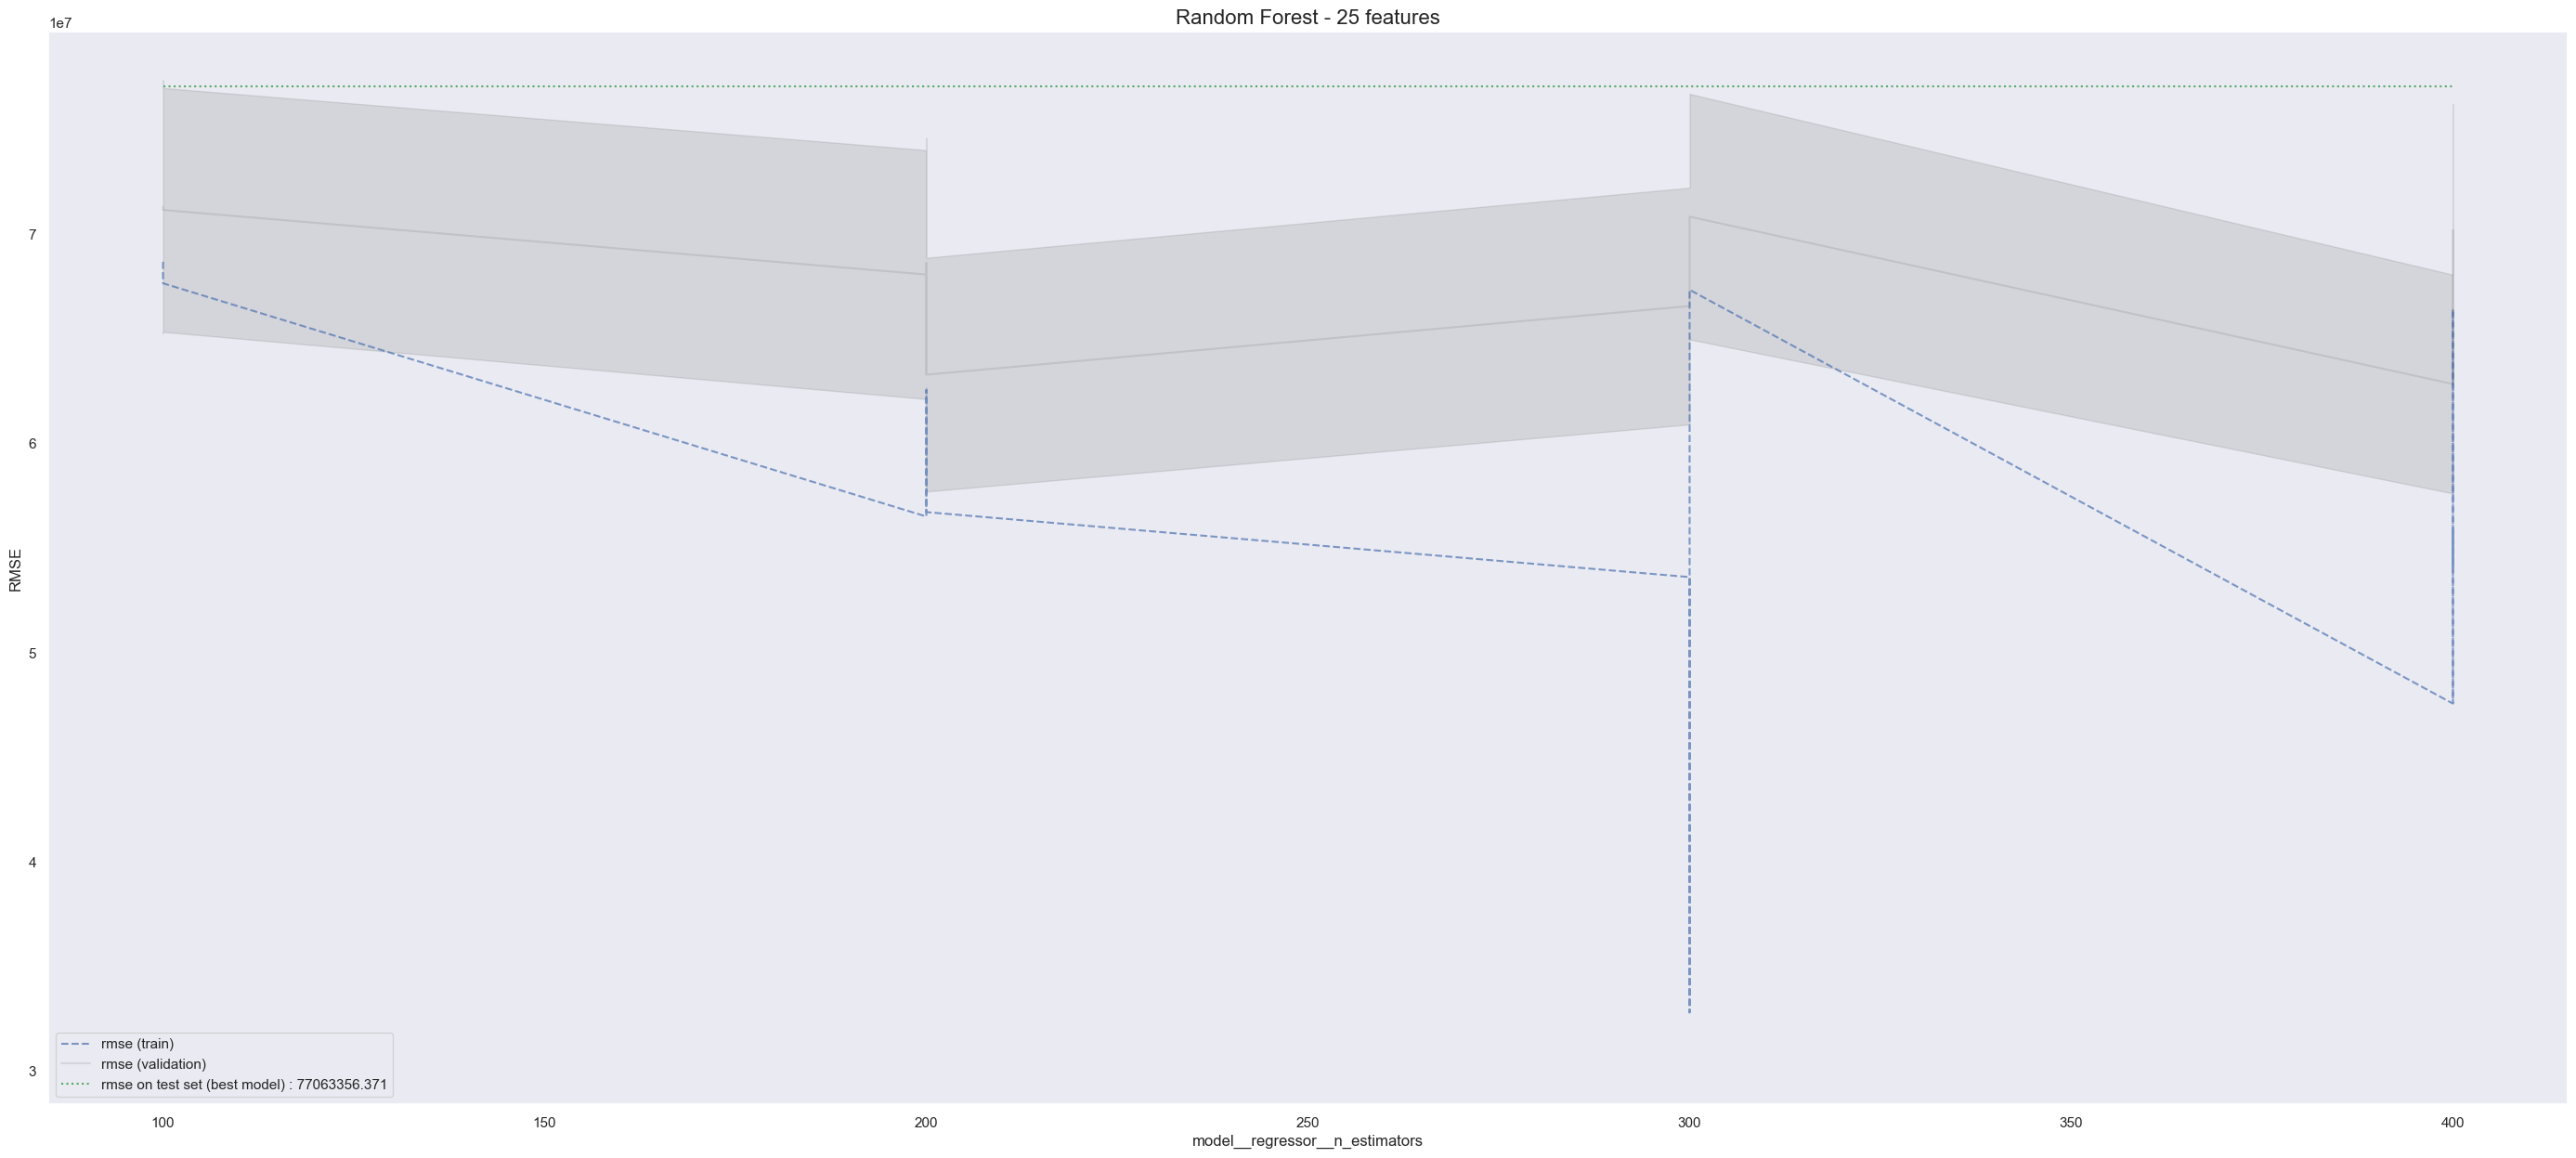

In [179]:
evaluate_model(rf, rf_results, filename="rf_eval")

In [171]:
rf_results["hyperparameters"][np.argmin(rf_results["test_scores"])]

OrderedDict([('model__regressor__bootstrap', True),
             ('model__regressor__max_depth', 130),
             ('model__regressor__max_features', 'auto'),
             ('model__regressor__min_samples_leaf', 1),
             ('model__regressor__min_samples_split', 5),
             ('model__regressor__n_estimators', 400)])

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.

['n_votes', 'runtime', 'release_year', 'studio_MGM', 'studio_NL', 'studio_IFC', 'studio_Mira.', 'studio_Uni.', 'studio_Fox', 'studio_BV', 'studio_Par.', 'studio_WB', 'studio_Magn.', 'studio_Strand', 'studio_SPC', 'studio_Orion', 'studio_Col.', 'studio_Gold.', 'studio_Sony', 'studio_FoxS', 'studio_Eros', 'studio_Reg.', 'genre_Drama', 'genre_Comedy', 'genre_Crime', 'genre_Action', 'genre_Adventure', 'genre_Documentary', 'genre_Family', 'img_feature0', 'img_feature3', 'img_feature4', 'text_feature1', 'text_feature2', 'text_feature4']


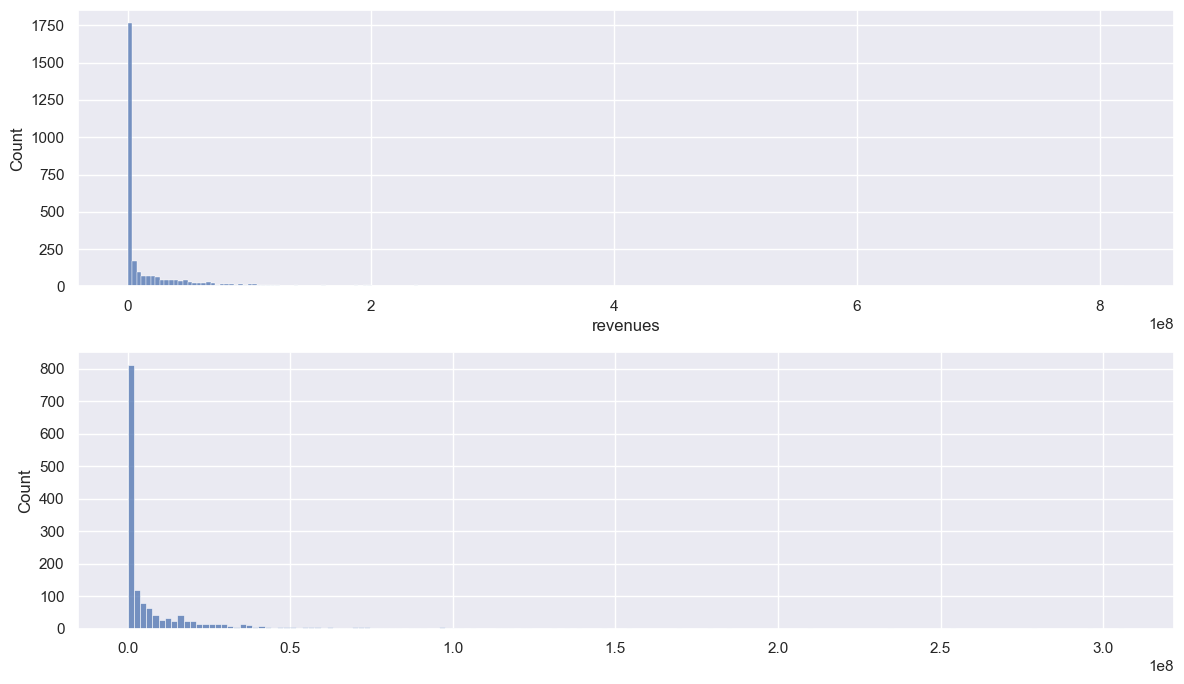

In [180]:
fig, ax = plt.subplots(2, figsize=(12,7))
sns.set(rc={"figure.figsize": (9, 14)})

best_model = mlp_results["best_estimators"][np.argmin(mlp_results["test_scores"])]
features = mlp_results["features"][np.argmin(mlp_results["test_scores"])]
print(features)

assert len(X2) == 1518

Y2 = best_model.predict(X2[features].fillna(0))

sns.histplot(Y, ax=ax[0])
sns.histplot(Y2, ax=ax[1])
fig.tight_layout()

plt.savefig("report/figures/prediction_histogram.pdf", dpi=300)

In [188]:
mlp_results["test_scores"][np.argmin(mlp_results["test_scores"])]

73850742.485

In [189]:
Y2 = np.insert(Y2, Y2.size, mlp_results["test_scores"][np.argmin(mlp_results["test_scores"])])

In [190]:
pd.DataFrame(Y2.T).to_csv("results/Y2.csv", header=False, index=False)